In [1]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

<IPython.core.display.Javascript object>

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [130]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
l = 11
qBase = np.array([[2,16],[20,14],
                 [27,6],[28,23],
                 [10,22],[11,39],
                 [30, 11],[48, 8],
                 [20, 35],[37, 40],
                 [32, 27],[48, 19]])

sub_regions = [[25,0,21,0],
               [35, 20, 23, 6],
               [20,0, 40, 17],
               [50, 25, 18, 3],
               [40, 17, 44, 26],
               [50, 30, 32, 14]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = np.array([0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta])

0.0625


In [131]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [132]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs

print(prob_pred_con)

Drawing 525 samples from Channel 1
Completed PredictedChannel 1
Drawing 525 samples from Channel 2
Completed PredictedChannel 2
Drawing 254 samples from Channel 3
Completed PredictedChannel 3
Drawing 254 samples from Channel 4
Completed PredictedChannel 4
Drawing 460 samples from Channel 5
Completed PredictedChannel 5
Drawing 460 samples from Channel 6
Completed PredictedChannel 6
Drawing 375 samples from Channel 7
Completed PredictedChannel 7
Drawing 375 samples from Channel 8
Completed PredictedChannel 8
Drawing 414 samples from Channel 9
Completed PredictedChannel 9
Drawing 414 samples from Channel 10
Completed PredictedChannel 10
Drawing 360 samples from Channel 11
Completed PredictedChannel 11
Drawing 360 samples from Channel 12
Completed PredictedChannel 12
[0.7686496694995278, 0.8253327954820492, 0.6628849270664505, 0.6301369863013698, 0.876969696969697, 0.7613776137761378]


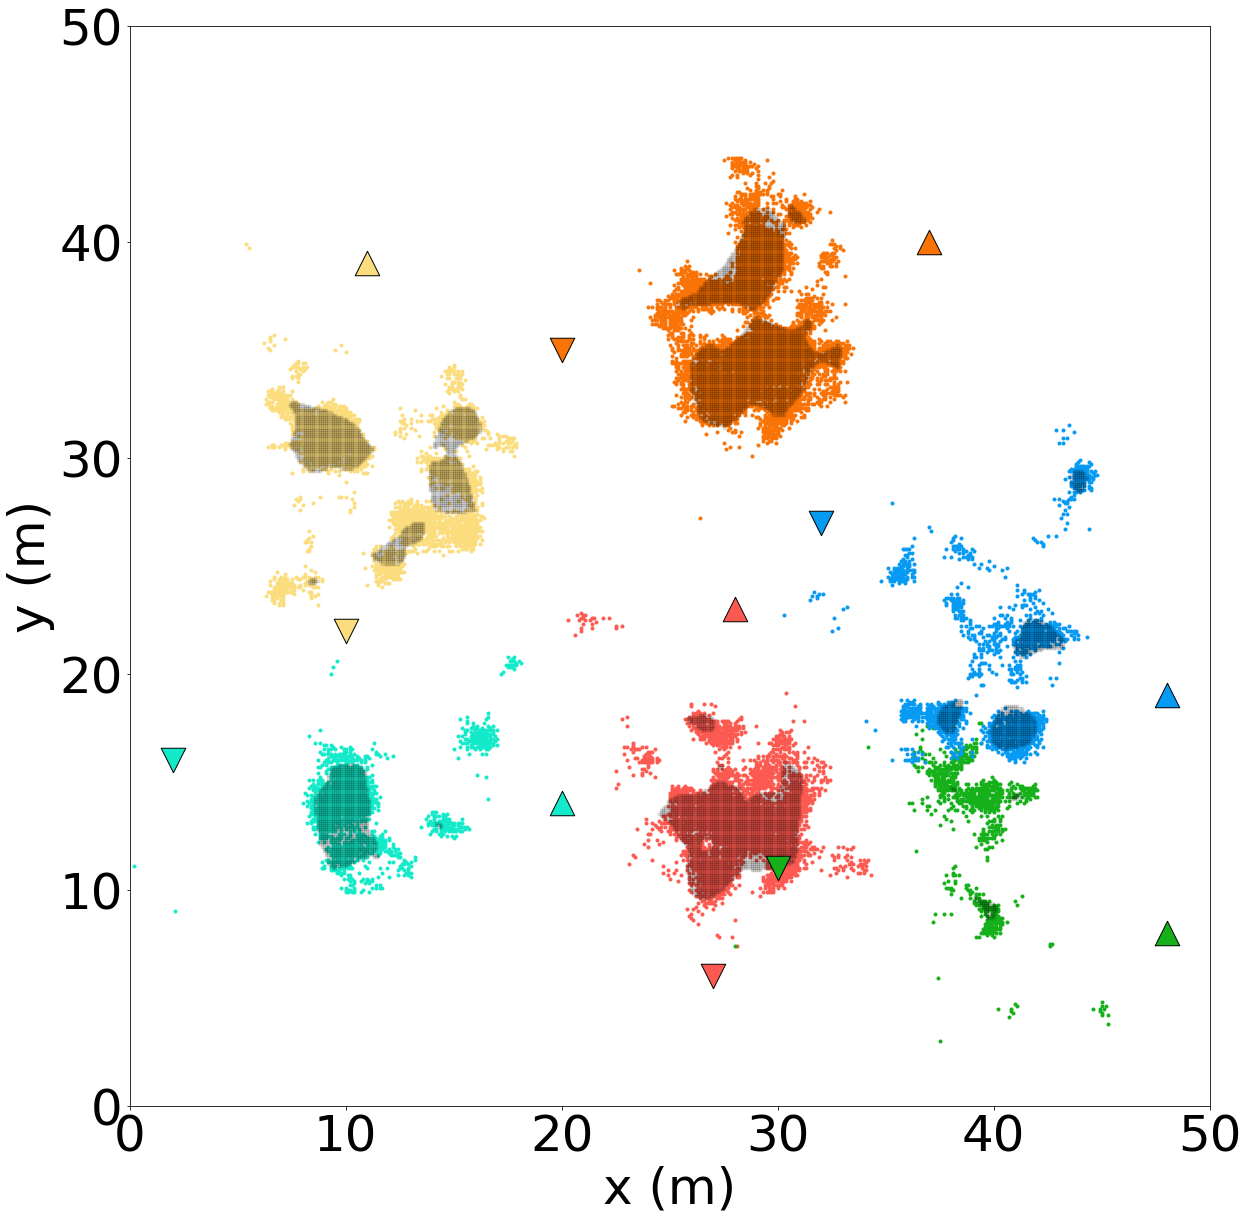

In [133]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [134]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
6 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([27.4 15.8])  ([27.3 15.8])  ([27.3 15.6])  ([27.4 15.6]) Is Interior: False
16 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
18 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([38.1 14.6])  ([38.2 14.6])  ([38.1 14.7])  ([38.  14.7]) Is Interior: False
3 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([29.  36.5])  ([28.9 36.9]) 
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
22 total

Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Optimal Solution Improved to 109.81
Working on Permutation (0, 1, 2, 3, 5, 4)
Optimal Solution Improved to 94.25
Working on Permutation (0, 1, 2, 4, 3, 5)
Optimal Solution Improved to 84.39
Working on Permutation (0, 1, 2, 4, 5, 3)
Optimal Solution Improved to 81.90
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
Working on Permutation (0, 1, 3, 5, 2, 4)
Working on Permutation (0, 1, 3, 5, 4, 2)
Optimal Solution Improved to 70.39
Working on Permutation (0, 1, 4, 2, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 5, 3)
skiping based on lower bound
W

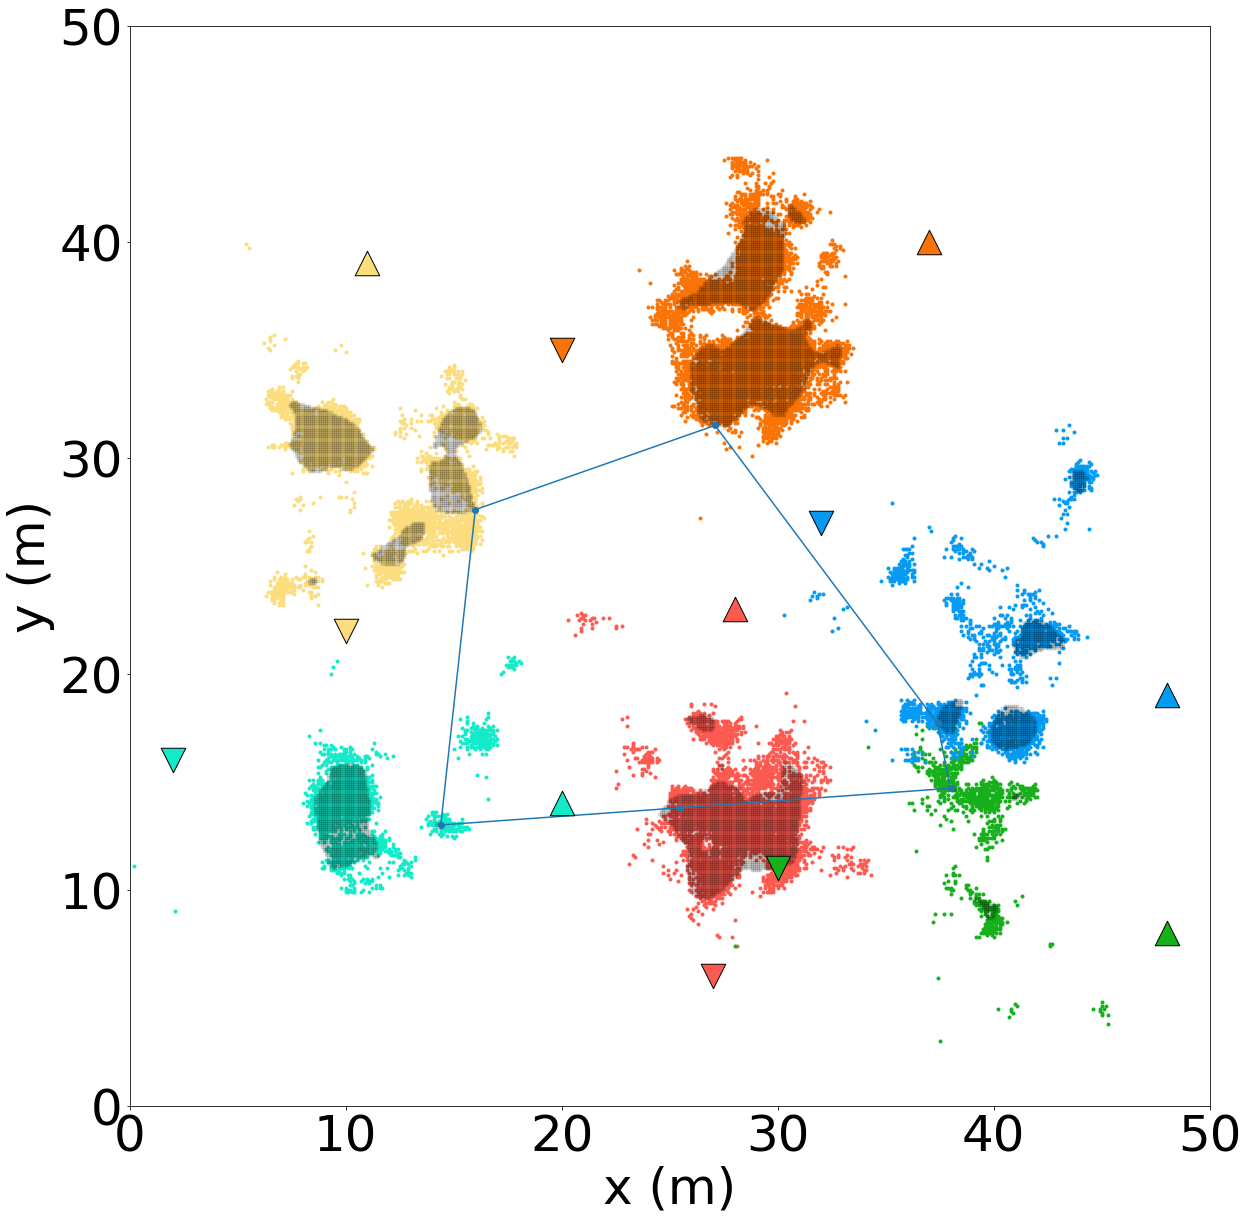

In [135]:
reload(sim)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

In [136]:
reload(sim)
reload(PS)
v = 1
ps = dt_sys.ps
#ratios OK, let's just reduce the overall traffic
els = np.array([0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta])
sys_traffic = 0.2
els = np.array([0.01, 0.2, 0.01, 0.2, 0.01, 0.2])
els = (els/sum(els))*sys_traffic/beta
ps.Ls = els

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

#S_i = S @ pi
W_rnd = ps._calc_avg_wait_random(S, pi)
W_cy = ps._calc_avg_wait_cyclic(S_cyv)

#print(S)
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
S_i = np.diag(P_tilde@S)
print(els)
print(pi)
print(pi_tilde)
print(S_i)
print(W_rnd)
print(W_cy)

Finding AORP
Found AORP
[[0.         0.22481833 0.01694821 0.35641972 0.02136156 0.38045219]
 [0.02228618 0.         0.02137628 0.4495417  0.02694271 0.47985314]
 [0.01765689 0.22465626 0.         0.35616278 0.02134616 0.38017792]
 [0.02672155 0.33998996 0.02563057 0.         0.03230482 0.5753531 ]
 [0.0177351  0.22565142 0.01701101 0.35774047 0.         0.381862  ]
 [0.02772935 0.35281258 0.02659722 0.55933767 0.03352319 0.        ]]
[0.05079365 1.01587302 0.05079365 1.01587302 0.05079365 1.01587302]
[0.01736283 0.22091485 0.01665394 0.35023126 0.02099066 0.37384646]
[0.02480736 0.25025148 0.02381169 0.33088764 0.02987995 0.34036189]
[22.06672695  7.67144279 23.26383347  5.71217198 17.61136271  5.77871486]
39.56111734803196
41.35330177878663


In [137]:
with np.printoptions(precision=3):
    print(P_tilde)

[[0.    0.225 0.017 0.356 0.021 0.38 ]
 [0.022 0.    0.021 0.45  0.027 0.48 ]
 [0.018 0.225 0.    0.356 0.021 0.38 ]
 [0.027 0.34  0.026 0.    0.032 0.575]
 [0.018 0.226 0.017 0.358 0.    0.382]
 [0.028 0.353 0.027 0.559 0.034 0.   ]]


In [138]:
reload(sim)
hrs = 2
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

Velocity = 1.000000
Theotretical MB serviced: 23039.999999999996
Theoretical Energy Consumption (J): 43286.4
	Th. WT	WT	E (J)	MBS	MBR
AORP	39.56	38.22	43399.36	22899.40	154.40
Tab	---	30.73	43355.00	22941.75	102.30
TSPN	---	41.16	43418.41	22842.25	194.10
done


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

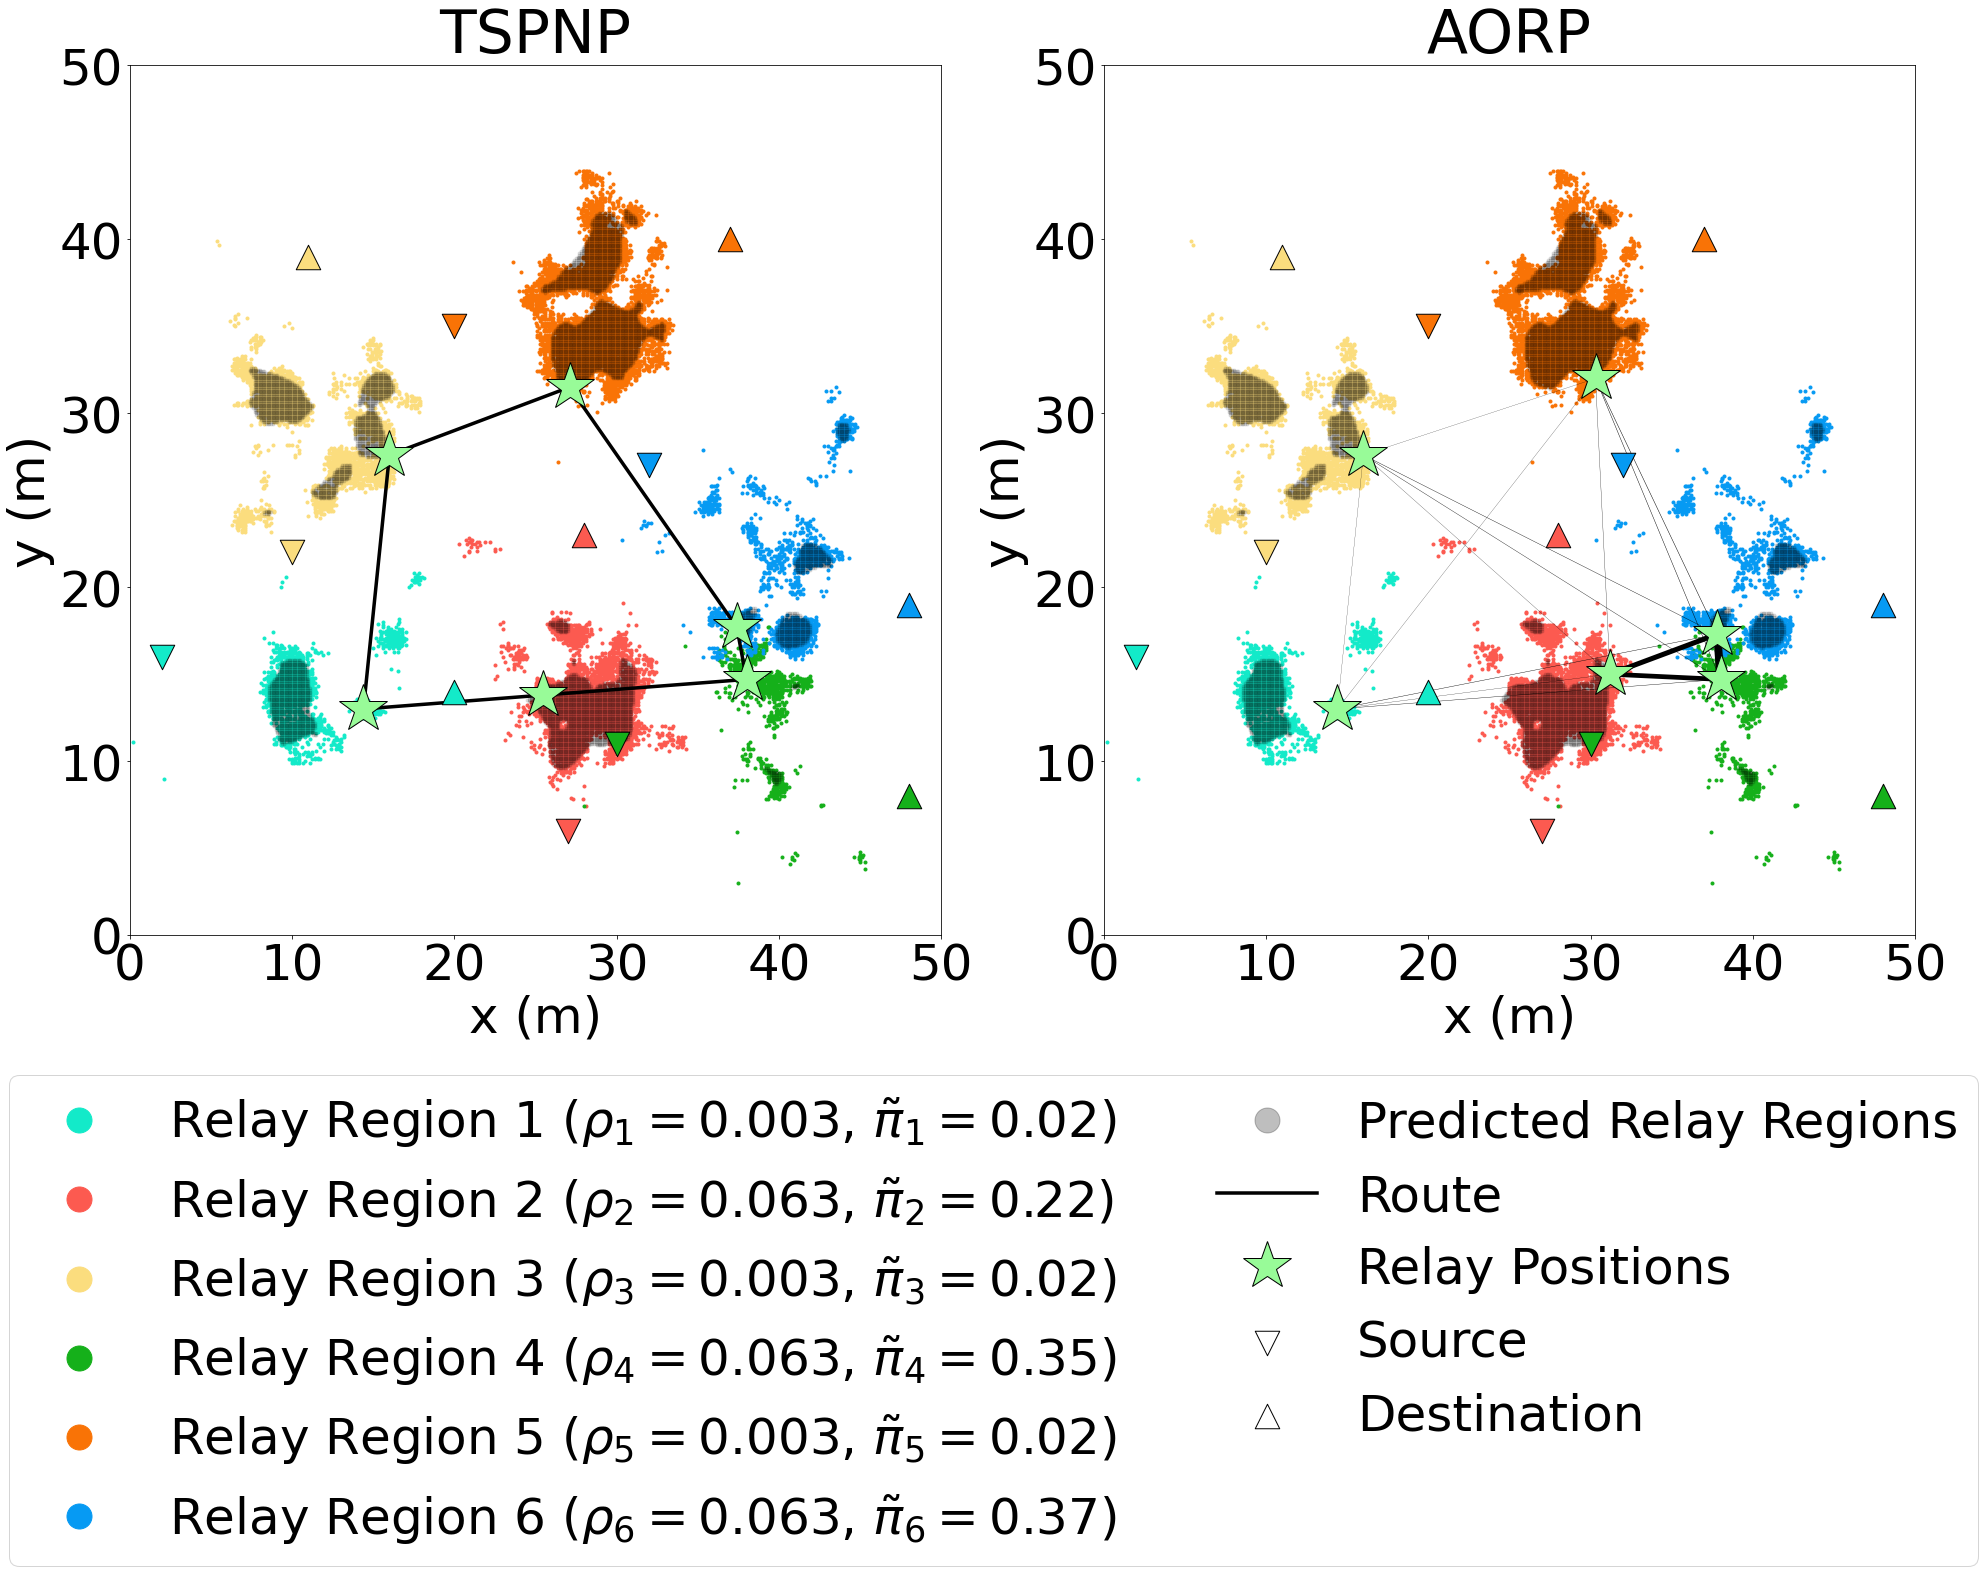

In [139]:
reload(sim)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, els*beta, AORP['pi'])

plt.savefig("six_spread_TSPNP_v_AORP.png", format='png', bbox_inches='tight')
plt.savefig("six_spread_TSPNP_v_AORP.eps", format='eps', bbox_inches='tight')

In [140]:
import StaticRP as SRP
rtable = SRP.SRPFromPis(pi, eps=0.01)
seq = np.array(rtable.seq)
ls = len(seq)
table_transitions = np.zeros((n,n))
empty =0
for i in range(ls):
    if seq[i] != seq[(i+1)%ls]:
        table_transitions[seq[i], seq[(i+1)%ls]]+=1
    else:
        empty +=1

In [142]:
P = table_transitions/(ls-empty)
#now normalize each row
np.sum(P, axis=1)

array([0.01698302, 0.22077922, 0.01698302, 0.35064935, 0.02097902,
       0.37362637])

In [143]:
np.unique(seq, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 17, 221,  17, 351,  21, 374]))

In [144]:
np.sum(P, axis=1)

array([0.01698302, 0.22077922, 0.01698302, 0.35064935, 0.02097902,
       0.37362637])

In [145]:
with np.printoptions(precision=2):
    print((P.T/np.sum(P, axis=1)).T)

[[0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.01 0.6  0.   0.   0.   0.39]
 [0.   0.43 0.57 0.   0.   0.  ]
 [0.04 0.   0.01 0.94 0.01 0.  ]]


In [146]:
P_table = (P.T/np.sum(P, axis=1)).T


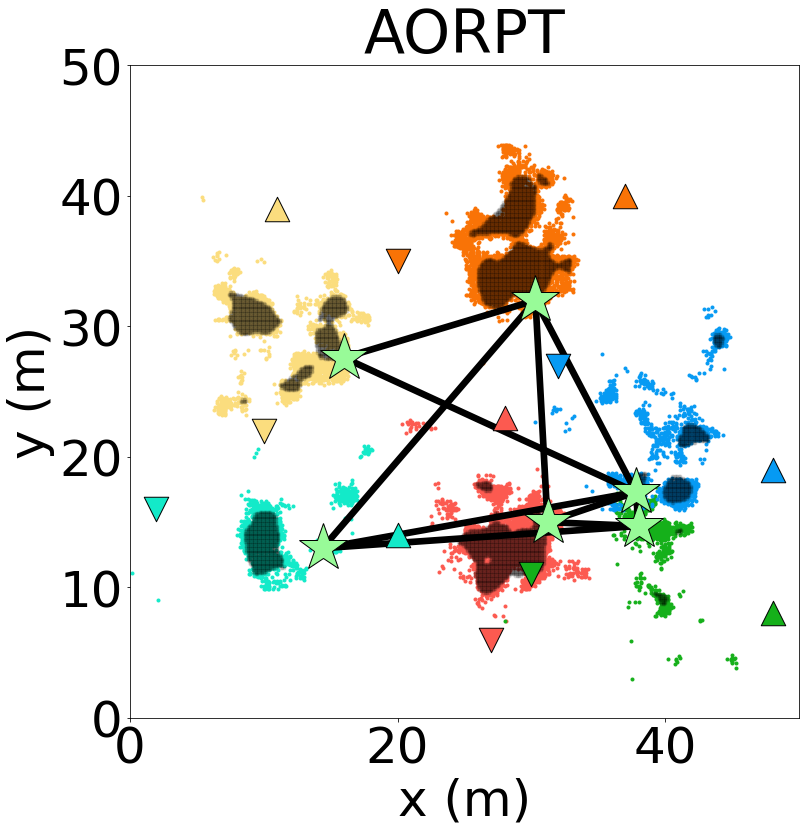

In [147]:
reload(sim)
AORPT={'seq': seq, 'X': AORP['X']}
sim.plot_AORPT(dt_sys, AORPT, tjcps, pjcps, qBase, region, rhos)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

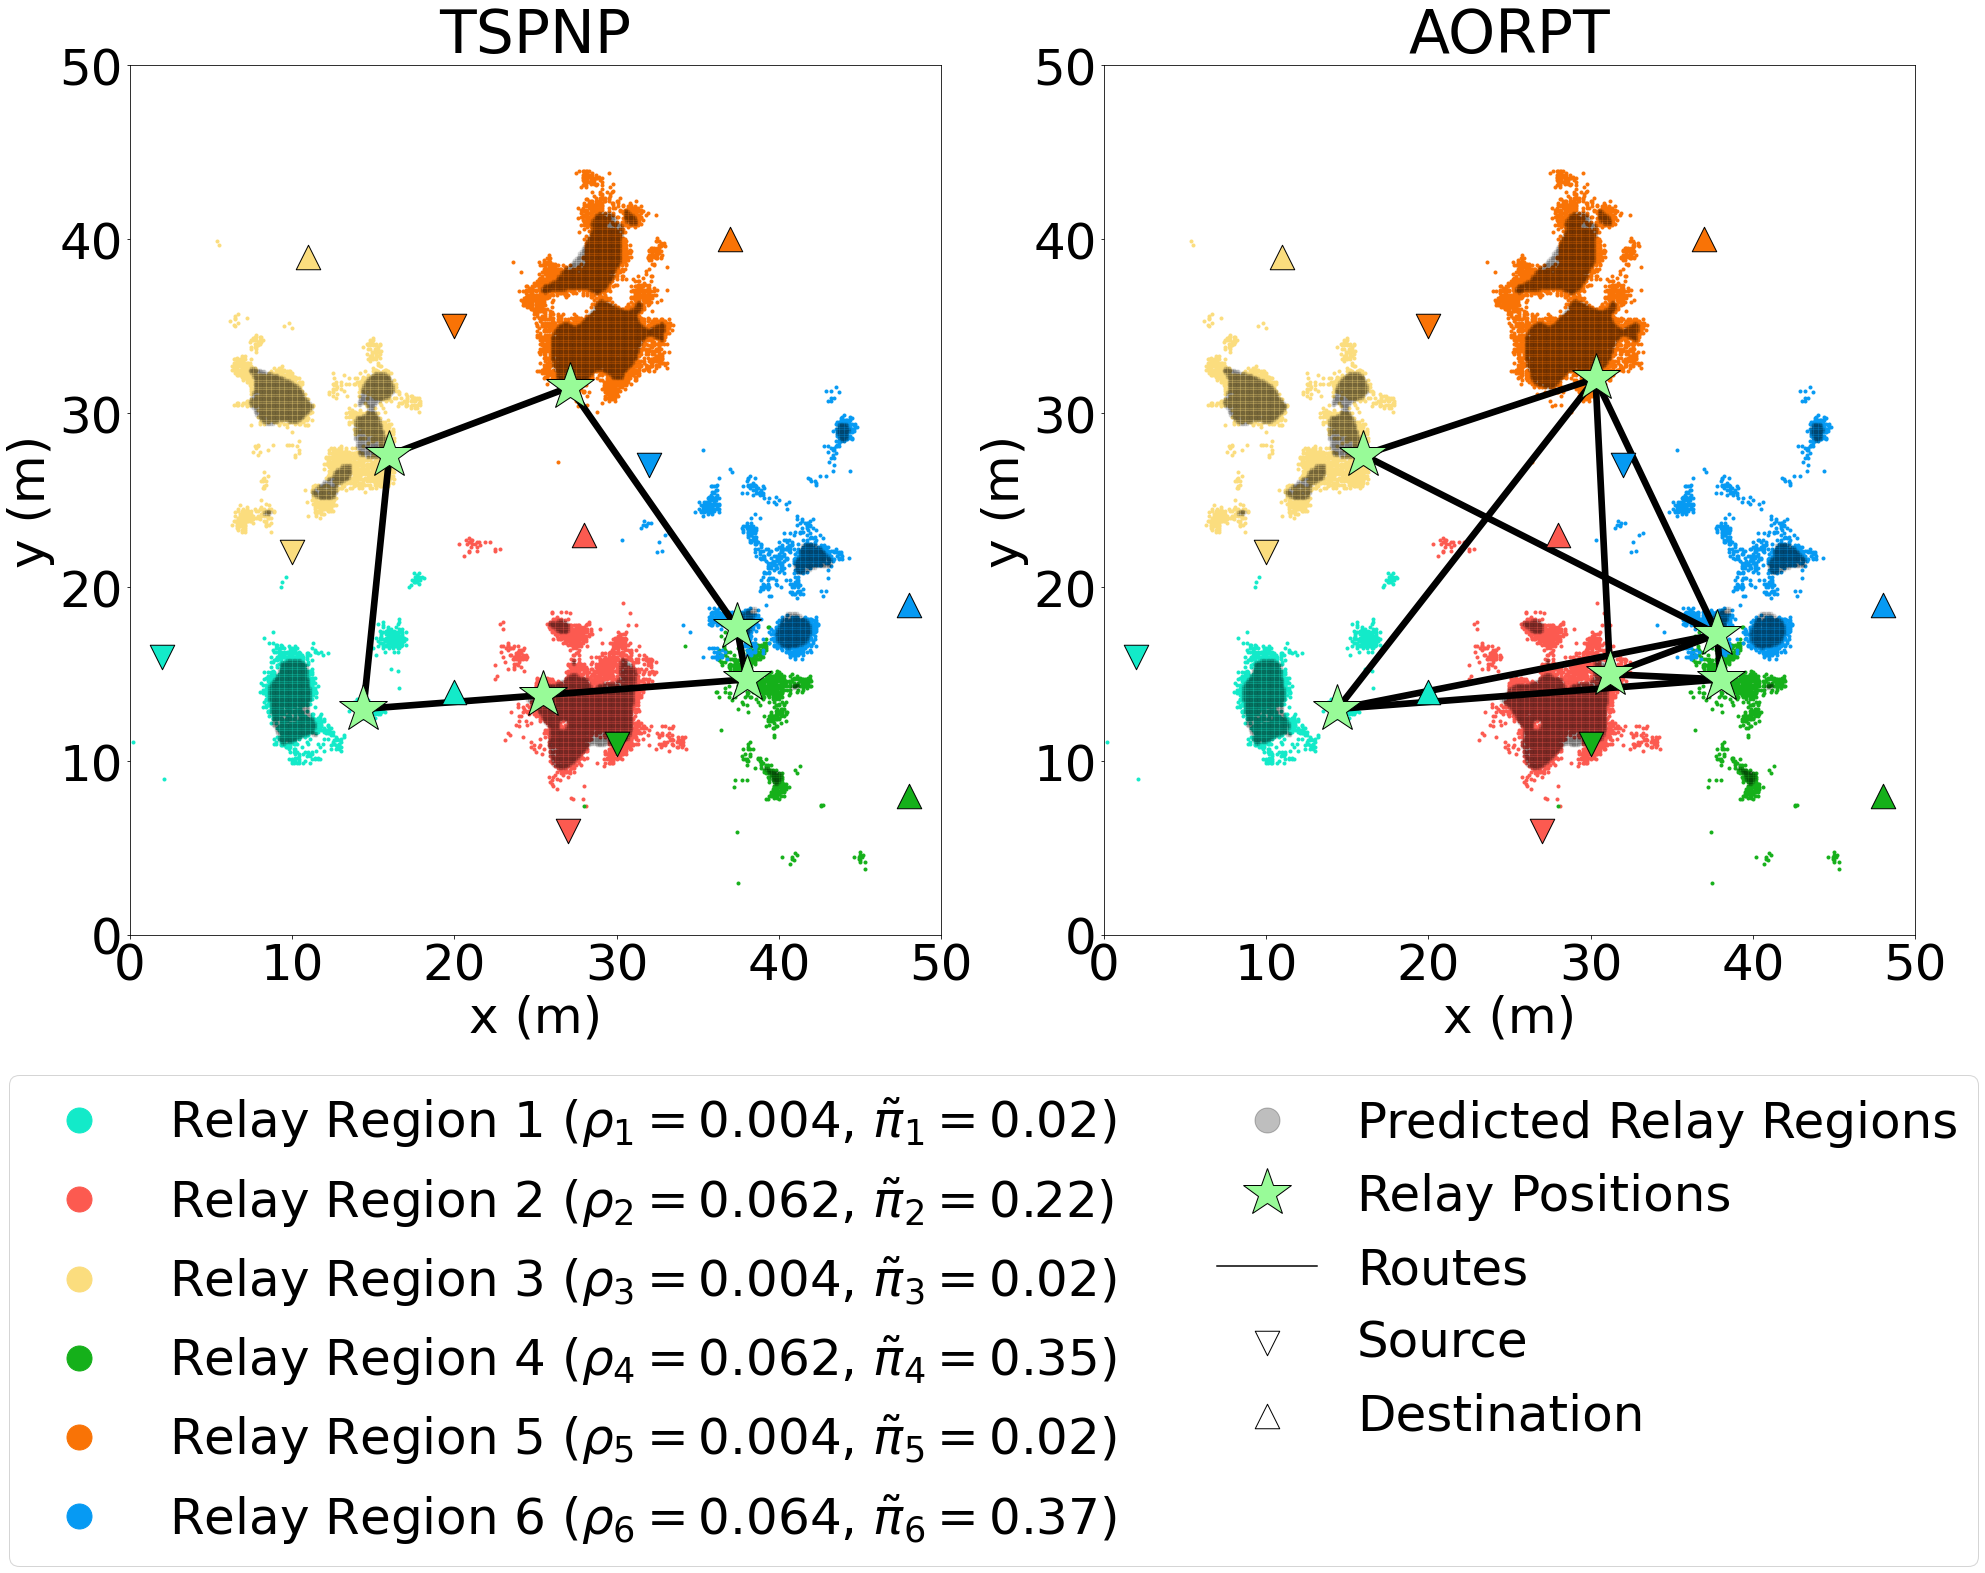

In [148]:
reload(sim)
sim.plot_AORPT_W_TSPN(dt_sys, AORPT, TSPNP, tjcps, pjcps, qBase, region, rhos)
plt.savefig("six_spread_TSPNP_v_AORPT.png", format='png', bbox_inches='tight')
plt.savefig("six_spread_TSPNP_v_AORPT.eps", format='eps', bbox_inches='tight')

In [102]:
AORPT['X']

array([[16.29999984,  8.69999888],
       [31.39999983, 15.59999984],
       [14.99999661, 30.2999978 ],
       [36.49999993, 11.79999981],
       [28.70000072, 27.10000133],
       [37.09999824, 18.90000186]])